# 1. Future Prediciton of Crime

08:54:24 - cmdstanpy - INFO - Chain [1] start processing
08:54:24 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\annar\OneDrive\Desktop\Visual Studio\GitHub\Projects4\CrimeHawk\crime\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\annar\OneDrive\Desktop\Visual Studio\GitHub\Projects4\CrimeHawk\crime\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\annar\OneDrive\Desktop\Visual Studio\GitHub\Projects4

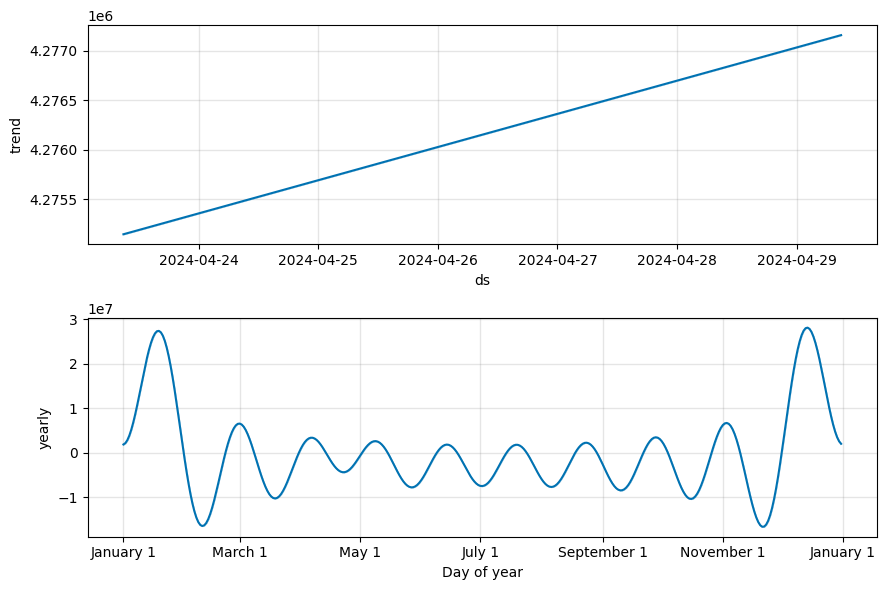

In [9]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
from prophet import Prophet
import matplotlib.pyplot as plt
import datetime

# Load the dataset
data = pd.read_csv('data/crime2001_2012.csv')

# Ensure 'YEAR' is in a proper date format
data['YEAR'] = pd.to_datetime(data['YEAR'].astype(str) + "-01-01")

# Get the current date
current_date = datetime.datetime.now()

# Extend the data to include at least the current date
latest_date = data['YEAR'].max()
if latest_date < current_date:
    current_row = pd.DataFrame({
        'STATE/UT': ["UNKNOWN"],  # Use an appropriate value for your context
        'YEAR': [current_date],
        'TOTAL IPC CRIMES': [0]  # Default value; adjust as needed
    })
    data = pd.concat([data, current_row], ignore_index=True)

# Group by year and sum total IPC crimes
crime_ts = data.groupby(['YEAR'])['TOTAL IPC CRIMES'].sum().reset_index()

# Rename columns for Prophet
crime_ts.rename(columns={'YEAR': 'ds', 'TOTAL IPC CRIMES': 'y'}, inplace=True)

# Create a Prophet model
model = Prophet()

# Fit the model
model.fit(crime_ts)

# Generate future dates for prediction
# We use the current date and add the desired number of future days
future_dates = pd.date_range(current_date, periods=7, freq='D')

# Convert to DataFrame with 'ds' column for Prophet
future_dates_df = pd.DataFrame({'ds': future_dates})

# Predict future values
forecast = model.predict(future_dates_df)

# Plot the forecast components (trend, weekly, yearly seasonality)
fig2 = model.plot_components(forecast)
plt.show()

# 2. Simple Regression to get crime rates for future

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Load your dataset (replace 'crime_data.csv' with your dataset)
data = pd.read_csv('data/crime2001_2012.csv')

# Ensure proper categorical encoding for STATE/UT and DISTRICT
for col in ['STATE/UT', 'DISTRICT']:
    if data[col].dtype != 'category':
        data[col] = data[col].astype('category')

# Convert the STATE/UT and DISTRICT to numeric codes
data['STATE/UT'] = data['STATE/UT'].cat.codes
data['DISTRICT'] = data['DISTRICT'].cat.codes

# Ensure 'YEAR' is an integer
data['YEAR'] = data['YEAR'].astype(int)

# Select the features and the crime types to predict
feature_columns = ['STATE/UT', 'DISTRICT', 'YEAR']
crime_types = ['MURDER', 'RAPE', 'THEFT', 'BURGLARY', 'ROBBERY', 'KIDNAPPING & ABDUCTION']

# Prepare the feature matrix and the target matrix
X = data[feature_columns]
y = data[crime_types]

# Check for missing values or invalid data
if X.isnull().any().any() or y.isnull().any().any():
    raise ValueError("Dataset contains missing or invalid data")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train a Random Forest regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Collect user input for prediction
user_input = {
    'STATE/UT': input("Enter State/UT: "),
    'DISTRICT': input("Enter District: "),
    'YEAR': int(input("Enter Year: "))
}

# Convert the user input to a DataFrame
user_input_df = pd.DataFrame([user_input])

# Convert the categorical user input to numerical codes
user_input_df['STATE/UT'] = pd.Categorical(user_input_df['STATE/UT'], categories=data['STATE/UT'].cat.categories).codes
user_input_df['DISTRICT'] = pd.Categorical(user_input_df['DISTRICT'], categories=data['DISTRICT'].cat.categories).codes

# Predict the rates for various crime types
predicted_rates = model.predict(user_input_df)

# Display the predicted crime rates
for crime, rate in zip(crime_types, predicted_rates[0]):
    print(f"Predicted {crime} Rate:", rate)

# 3. Classification of crimes in various states and districts

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load the dataset (ensure the correct file path)
data = pd.read_csv('data/crime2001_2012.csv')

# Convert categorical columns to numerical codes
for col in ['STATE/UT', 'DISTRICT']:
    data[col] = data[col].astype('category').cat.codes

# Feature columns for classification
feature_columns = ['STATE/UT', 'DISTRICT', 'YEAR']

# Define a crime profile threshold (using total IPC crimes)
threshold = data['TOTAL IPC CRIMES'].median()  # Separate high-crime and low-crime
data['CRIME_PROFILE'] = (data['TOTAL IPC CRIMES'] > threshold).astype(int)  # 1 for high-crime, 0 for low-crime

# Prepare features and target for the model
X = data[feature_columns]
y = data['CRIME_PROFILE']

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Classification Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Get user input for classification
user_input = {
    'STATE/UT': input("Enter State/UT: "),
    'DISTRICT': input("Enter District: "),
    'YEAR': None  # Initialize to None to handle invalid input
}

# Ensure YEAR is a valid integer
while user_input['YEAR'] is None:
    try:
        user_input['YEAR'] = int(input("Enter Year (number): "))
    except ValueError:
        print("Invalid input for YEAR. Please enter a valid integer.")

# Convert the user input to DataFrame
user_input_df = pd.DataFrame([user_input])

# Convert user input columns to numerical codes for classification
try:
    user_input_df['STATE/UT'] = pd.Categorical(user_input_df['STATE/UT'], categories=data['STATE/UT'].cat.categories).codes
    user_input_df['DISTRICT'] = pd.Categorical(user_input_df['DISTRICT'], categories=data['DISTRICT'].cat.categories).codes
except Exception as e:
    print(f"Error in converting user input to categorical codes: {e}")
    raise

# Predict the crime profile for the given input
predicted_profile = model.predict(user_input_df)

# Output the classification result
classification_result = "High-Crime" if predicted_profile[0] == 1 else "Low-Crime"
print(f"The predicted crime profile for the given state/district is: {classification_result}")

Classification Accuracy: 0.7422394678492239
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.71      0.74       908
           1       0.73      0.77      0.75       896

    accuracy                           0.74      1804
   macro avg       0.74      0.74      0.74      1804
weighted avg       0.74      0.74      0.74      1804

Error in converting user input to categorical codes: Can only use .cat accessor with a 'category' dtype


AttributeError: Can only use .cat accessor with a 'category' dtype